## Time Series Forecasting of 30-year Mortgage Rates

This dataset was obtained from the Federal Reserve Bank of St Louis here: https://fred.stlouisfed.org/series/MORTGAGE30US

This time-series data is recorded weekly and begins on April 2nd, 1971 and goes until the present day (June 27th, 2024). There are 2 columns in this dataset: observation_date and MORTGAGE30US. For the purpose of this study, we will use data ending on or before December 31, 2022, and use it to forecast mortgage prices for the year of 2023. 

We will be using the following forecasting methods: <br>
1) Exponential Smoothing <br>
2) Autoregressive Integrated Moving Average (ARIMA) <br>

We will conclude with an analysis on results.

### Exploratory Data Analysis

In [164]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
pd.options.mode.chained_assignment = None  # default='warn'

In [165]:
df = pd.read_excel("datasets/MORTGAGE30US.xls")
df.head()

,FRED Graph Observations,Unnamed: 1
0,Federal Reserve Economic Data,NaN
1,Link: https://fred.stlouisfed.org,NaN
2,Help: https://fredhelp.stlouisfed.org,NaN
3,Economic Research Division,NaN
4,Federal Reserve Bank of St. Louis,NaN


In [166]:
# It looks like the data begins lower down in the spreadsheet. Let's find the row where the column headers are located.
df.loc[df['FRED Graph Observations'] == "observation_date"]

,FRED Graph Observations,Unnamed: 1
9,observation_date,MORTGAGE30US


In [167]:
# Let's reset the column names and create a new dataset without the first 10 rows
df.columns = ['observation_date', 'mortgage']
df = df.iloc[10:]
df.reset_index(drop=True)

,observation_date,mortgage
0,1971-04-02 00:00:00,7.33
1,1971-04-09 00:00:00,7.31
2,1971-04-16 00:00:00,7.31
3,1971-04-23 00:00:00,7.31
4,1971-04-30 00:00:00,7.29
...,...,...
2774,2024-05-30 00:00:00,7.03
2775,2024-06-06 00:00:00,6.99
2776,2024-06-13 00:00:00,6.95
2777,2024-06-20 00:00:00,6.87


In [168]:
# check for any NAs within the dataframe
df.isna().sum()

observation_date    0
mortgage            0
dtype: int64

In [169]:
# Now that the table is in the right format, let's make sure the columns are the right data type.
df['observation_date'] = pd.to_datetime(df['observation_date'])
df['mortgage'] = df['mortgage'].astype('float')
print(df.dtypes)
# drop 2024 data as it will not be part of this analysis
df = df[df['observation_date'] < '2024-01-01']

observation_date    datetime64[ns]
mortgage                   float64
dtype: object


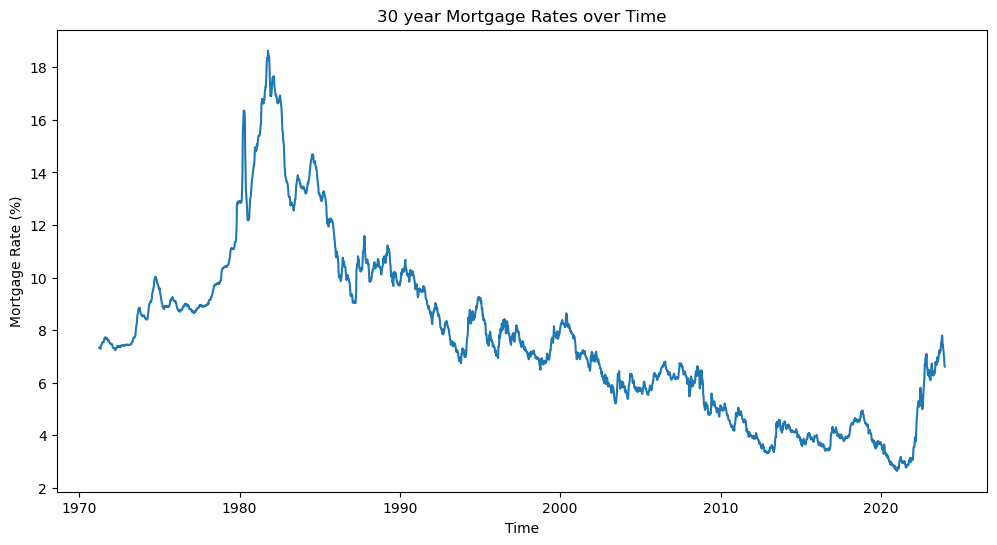

In [170]:
# Plot original time series data
plt.figure(figsize=(12, 6))
plt.plot(df['observation_date'], df['mortgage'])
plt.xlabel('Time')
plt.ylabel('Mortgage Rate (%)')
plt.title('30 year Mortgage Rates over Time')
plt.show()

The data appears to be non-stationary and exhibits seasonality. This will be important to consider for the ARIMA model, which requires stationary data. We may need to perform differencing on the data.

### Exponential Smoothing

For this analysis we will use Holt's Exponential Smoothing (vs Simple Exponential Smoothing or Double Exponential Smoothing), since there is a trend in the data. This article was used as a reference: https://chrisgrannan.medium.com/time-series-analysis-with-exponential-smoothing-d3ad82d47ab0

In [171]:
# Filter data to exclude 2023 onwards
df22 = df[df['observation_date'] < '2023-01-01']

In [173]:
# Format columns
df22['observation_date'] = pd.to_datetime(df22['observation_date'])
df22 = df22.set_index('observation_date')

/home/dramadas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dramadas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


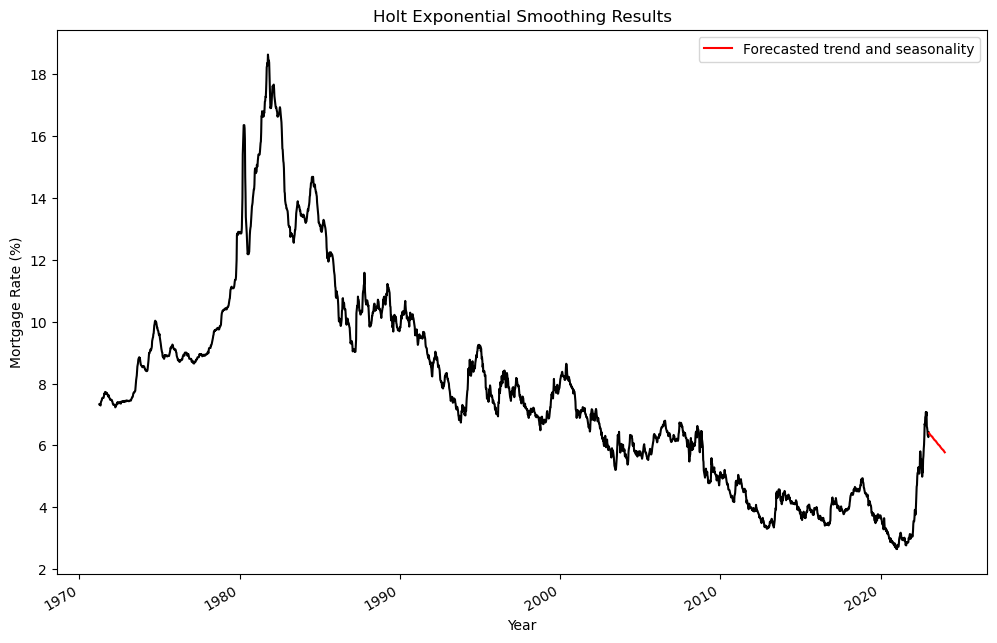

In [174]:
# Using trend and seasonal = "add" because trend and seasonality do not appear to be exponential/multiplicative
model = ExponentialSmoothing(df22, trend='add', seasonal='add',seasonal_periods=12).fit()
forecast = model.forecast(52)
forecast.index = pd.date_range(start='2023-01-05', periods=52, freq='W') # to set the start date of the forecast
# Plot the data till 2022 plus the forecast data
plt.figure(figsize=(12, 8))
plt.plot(df22, color="black")
forecast.plot(color="red", label="Forecasted trend and seasonality")
plt.title('Holt Exponential Smoothing Results')
plt.xlabel('Year')
plt.ylabel('Mortgage Rate (%)')
plt.legend()
plt.show()

This forecast appears rather linear and does not appear to have captured trends. It is possible that this could be due to the model being unable to capture trends with the unpredictable nature of mortgage data, and the fact that we did not explicitly account for external factors such as the economy or spending factors when forecasting.

### ARIMA Model
As mentioned earlier, the ARIMA model needs stationary data. We will need to use differencing to achieve this. This article was used as a reference: https://medium.com/@evertongomede/forecasting-non-stationary-time-series-03b638a7cd50#:~:text=ARIMA%20Models%3A%20AutoRegressive%20Integrated%20Moving,autoregressive%20and%20moving%20average%20components.

In [175]:
# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

# If the p-value is greater than the significance level of 0.05, we cannot reject the null hypothesis
# If we do not reject H0, that means that there is insufficient evidence that the time series is stationary 
adf_test(df22['mortgage'])


ADF Statistic: -1.2622253443528937
p-value: 0.6462722975506664
Critical Values: {'1%': -3.4327823852838972, '5%': -2.8626146484288544, '10%': -2.5673420712931514}


Since the p-value = 0.646 > 0.05, we do not reject H0. The time series will be considered non-stationary for the rest of this analysis.

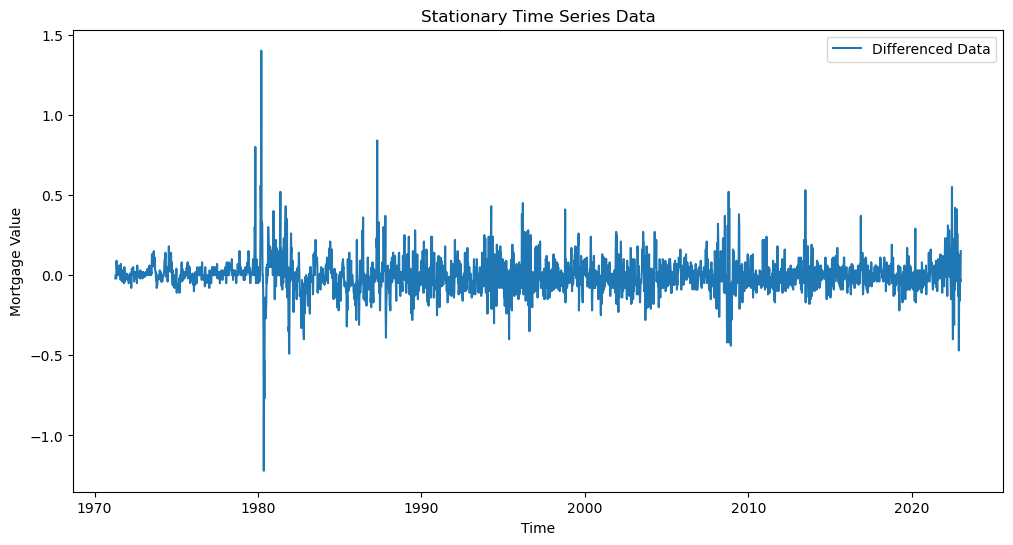

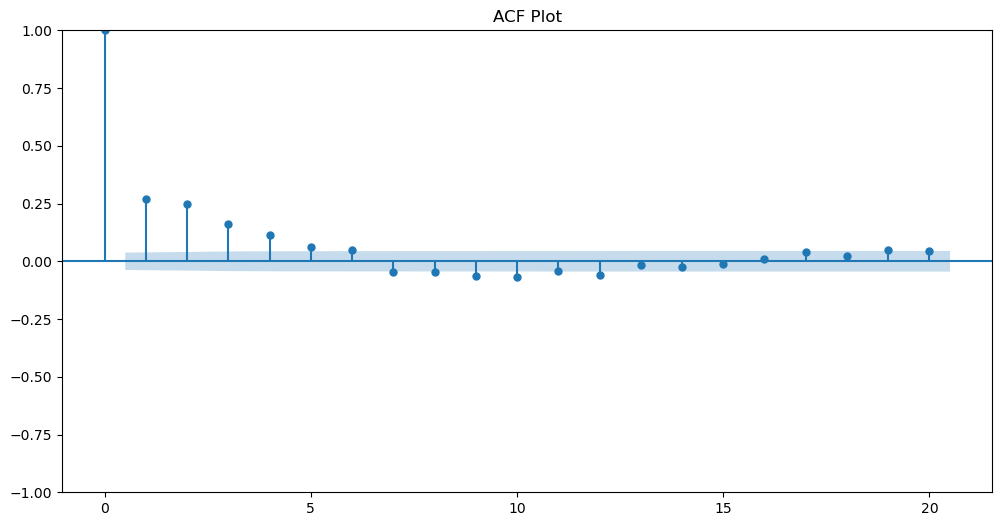

/home/dramadas/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


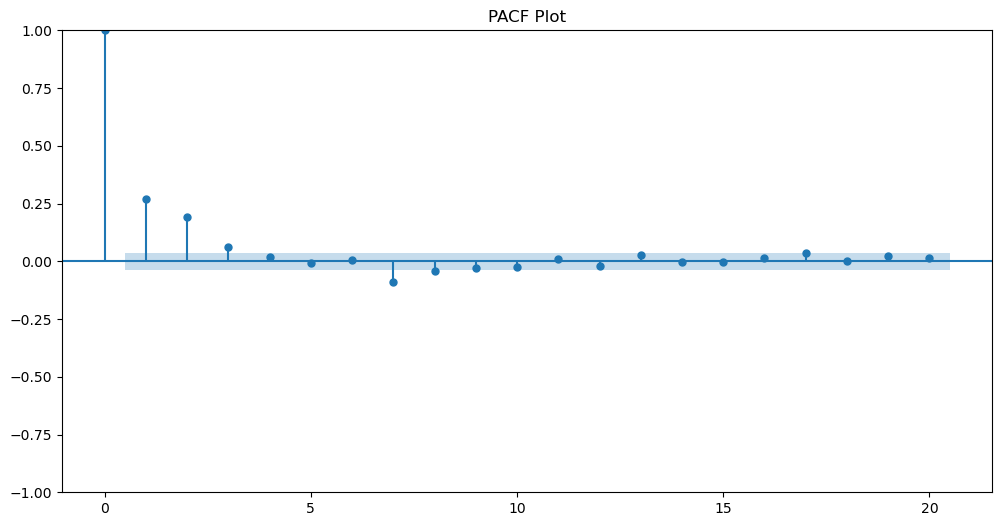

In [176]:
# Differencing to make the time series stationary
df22['Differenced_Data'] = df22['mortgage'] - df22['mortgage'].shift(1)
df22 = df22.dropna()

# Plot the differenced time series data
plt.figure(figsize=(12, 6))
plt.plot(df22.index, df22['Differenced_Data'], label='Differenced Data')
plt.xlabel('Time')
plt.ylabel('Mortgage Value')
plt.title('Stationary Time Series Data')
plt.legend()
plt.show()

# # ACF and PACF plots for determining ARIMA orders
plt.figure(figsize=(12, 6))
plot_acf(df22['Differenced_Data'], lags=20, ax=plt.gca())
plt.title('ACF Plot')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df22['Differenced_Data'], lags=20, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

In the ACF and PACF plots, the lags are significant at first then remain within the significance bound afterwards. First-order differencing (d=1) may be sufficient. There are 4 significant lags in the PACF plot (p=4). There are 5 significant lags in the ACF plot (q=5).

In [231]:
# Fit an ARIMA model to the Differenced data
model = ARIMA(df22['Differenced_Data'], order=(4, 1, 5)) # Based on values chosen above
model_fit = model.fit()

# Forecast the test data
forecast = model_fit.forecast(steps=len(test))
forecast.index = pd.date_range(start='2012-08-25', periods=len(test), freq='W') # to set the start date of the forecast

/home/dramadas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dramadas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dramadas/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dramadas/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

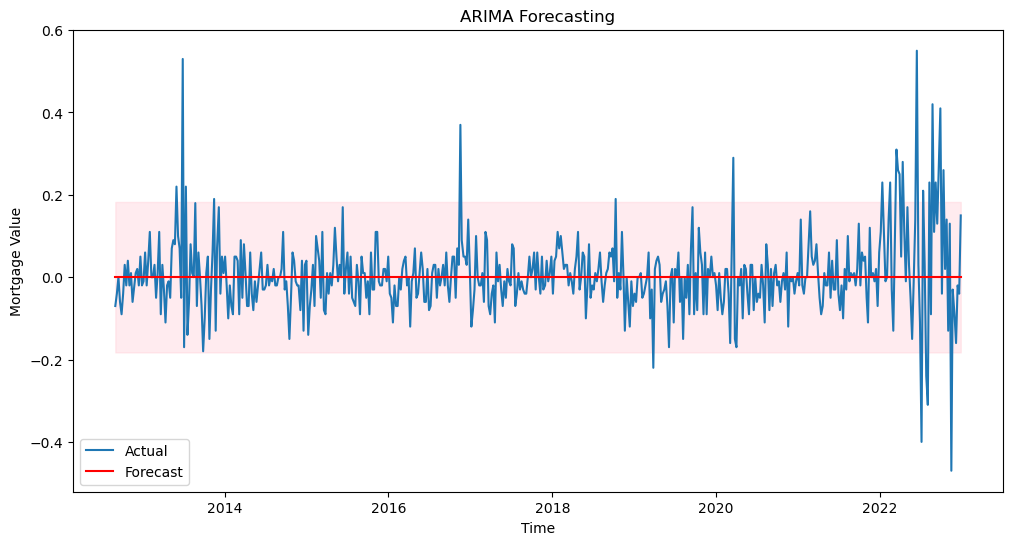

In [234]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df22))
train, test = df22['Differenced_Data'][:train_size], df22['Differenced_Data'][train_size:]

# Calculate prediction intervals
forecast = forecast.reindex(test.index,fill_value=0)
residuals = test - forecast
prediction_interval = 1.96 * np.std(residuals)  # 1.96 for a 95% prediction interval

# Plot the forecasts and the actual values with prediction intervals
plt.figure(figsize=(12, 6))
plt.plot(df22.index[train_size:], test, label='Actual')
plt.plot(df22.index[train_size:], forecast, label='Forecast', color='red')
plt.fill_between(df22.index[train_size:], forecast - prediction_interval, forecast + prediction_interval, color='pink', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Mortgage Value')
plt.title('ARIMA Forecasting')
plt.legend()
plt.show()

The model's forecast aligns relatively well with the observed data, indicating that the ARIMA model is capturing most of the variability in mortgage rates over time.

### Analysis and Future Work

Exponential Smoothing and ARIMA are two distinct approaches for forecasting time series data. Based on the results above, Exponential Smoothing may be more suited to datasets with clear trends and seasonality, while ARIMA appears to be more robust for capturing complex relationships in stationary data. In future, these models can be compared further by calculating metrics such as Mean Absolute Percentage Error to determine accuracy of the forecasts.